# Loan Default Prediction Project
This project aims to predict loan default status using Lending Club data. The workflow includes data cleaning, preprocessing, exploratory data analysis (EDA), feature selection, modeling, hyperparameter tuning, and model interpretation. Below is the improved code with detailed commentary for each step.

## 1. Data Cleaning and Preprocessing
### Import Necessary Libraries
We start by importing all the necessary libraries for data manipulation, visualization, modeling, and evaluation.

In [226]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Modeling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# Statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model interpretability
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

### Load the Dataset
We load the dataset into a pandas DataFrame for analysis.

In [227]:
pwd

'c:\\Users\\kiera\\OneDrive\\Documents\\GitHub\\dsif-git-main-project\\elvtr_main_project\\notebooks'

In [228]:
# Load the dataset
df = pd.read_csv("c:/Users/kiera/OneDrive/Documents/GitHub/dsif-git-main-project/elvtr_main_project/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv")

### Initial Data Exploration
Before proceeding, let's explore the data to understand its structure and identify missing values.

In [229]:
# Display the first few rows
df.head()

# Get data types and non-null counts
df.info()

# Check for missing values
missing_percent = df.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percent[missing_percent > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 143 entries, Unnamed: 0.1 to debt_settlement_flag
dtypes: float64(106), int64(3), object(34)
memory usage: 109.1+ MB
Percentage of missing values in each column:
emp_title                                      8.954
emp_length                                     6.950
title                                          0.780
dti                                            0.102
mths_since_last_delinq                        52.814
                                               ...  
hardship_dpd                                  95.105
hardship_loan_status                          95.116
orig_projected_additional_accrued_interest    93.873
hardship_payoff_balance_amount                93.778
hardship_last_payment_amount                  93.778
Length: 95, dtype: float64


### Handle Missing Values
We handle missing values appropriately based on the percentage and importance of the features.

In [230]:
# Impute missing values in 'loan_amnt' using KNN Imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df[['loan_amnt']] = imputer.fit_transform(df[['loan_amnt']])

# For 'emp_title', replace missing values with 'Unknown'
df['emp_title'].fillna('Unknown', inplace=True)

### Convert Data Types
Ensure that all data types are correct and consistent.

In [231]:
# Convert 'int_rate' to float
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0

# Convert 'issue_d' to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'])

### Remove Duplicate Records
Remove any duplicate records to prevent bias.

In [232]:
# Remove duplicate records
df.drop_duplicates(inplace=True)

### Handle Outliers
Handle outliers using capping (Winsorization) or transformation.

In [233]:
# Calculate IQR for 'annual_inc'
Q1 = df['annual_inc'].quantile(0.25)
Q3 = df['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Cap outliers at the upper and lower bounds
df['annual_inc_capped'] = np.where(
    df['annual_inc'] > upper_bound, upper_bound,
    np.where(df['annual_inc'] < lower_bound, lower_bound, df['annual_inc'])
)

# Alternatively, apply log transformation
df['annual_inc_log'] = np.log1p(df['annual_inc'])

In [234]:
# Standardize 'loan_amnt'
scaler = StandardScaler()
df['loan_amnt_scaled'] = scaler.fit_transform(df[['loan_amnt']])

# Create debt-to-income ratio
df['dti'] = df['loan_amnt'] / df['annual_inc']

# Extract 'issue_year' and 'issue_month' from 'issue_d'
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month


In [235]:
# One-Hot Encode 'home_ownership'
# One-Hot Encode 'home_ownership'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
home_ownership_encoded = encoder.fit_transform(df[['home_ownership']])
home_ownership_df = pd.DataFrame(
    home_ownership_encoded, 
    columns=encoder.get_feature_names_out(['home_ownership'])
)

# Extract top 20 frequent 'emp_title' and encode
top_titles = df['emp_title'].value_counts().nlargest(20).index
df['emp_title_categorical'] = df['emp_title'].apply(
    lambda x: x if x in top_titles else 'Other'
)
emp_title_encoded = pd.get_dummies(df['emp_title_categorical'], prefix='emp_title')

# Concatenate encoded features with the main DataFrame
df = pd.concat([df.reset_index(drop=True), home_ownership_df.reset_index(drop=True), emp_title_encoded.reset_index(drop=True)], axis=1)


In [236]:
# Define good and bad loan statuses
positive_status = ['Fully Paid', 'Current']
negative_status = ['Charged Off', 'Default', 'Late']

# Filter dataset to include only relevant statuses
df = df[df['loan_status'].isin(positive_status + negative_status)]

# Map 'loan_status' to binary values
df['loan_status_binary'] = df['loan_status'].apply(lambda x: 1 if x in negative_status else 0)

# EDA

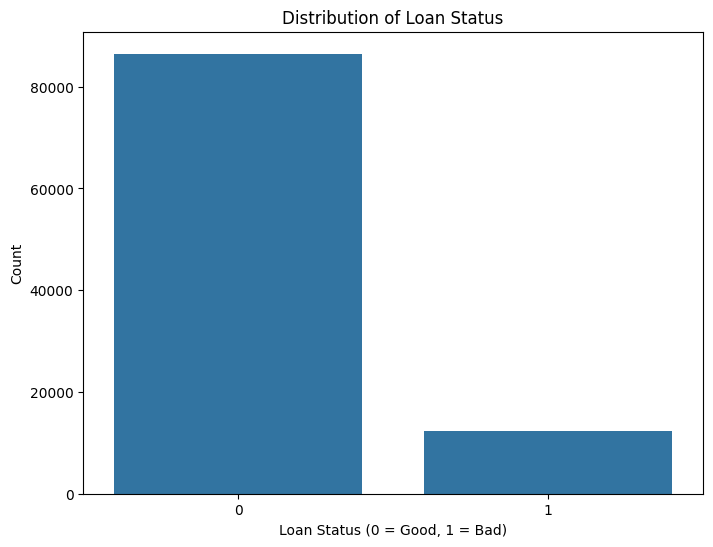

In [237]:
# Visualize distribution of loan status
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status_binary', data=df)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
plt.ylabel('Count')
plt.show()


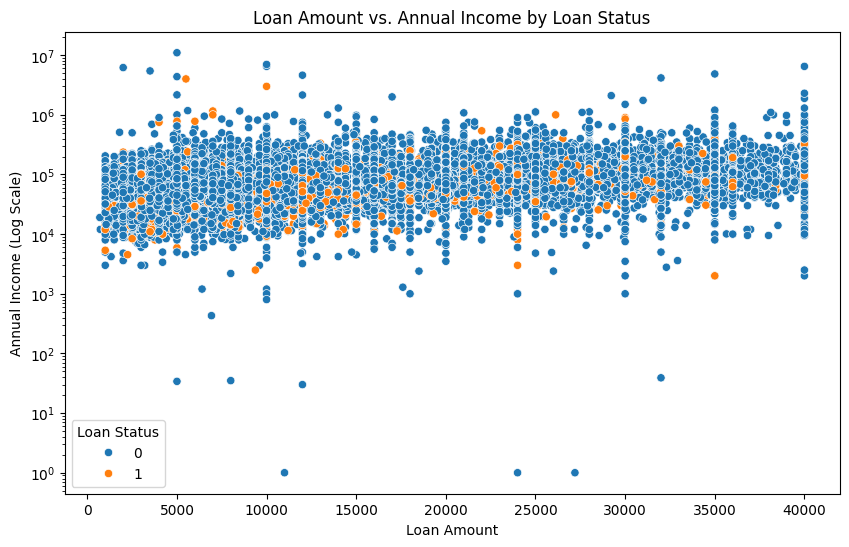

In [238]:
# Scatter plot of loan amount vs. annual income (log scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loan_amnt', y='annual_inc', hue='loan_status_binary', data=df)
plt.yscale('log')
plt.title('Loan Amount vs. Annual Income by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Annual Income (Log Scale)')
plt.legend(title='Loan Status')
plt.show()


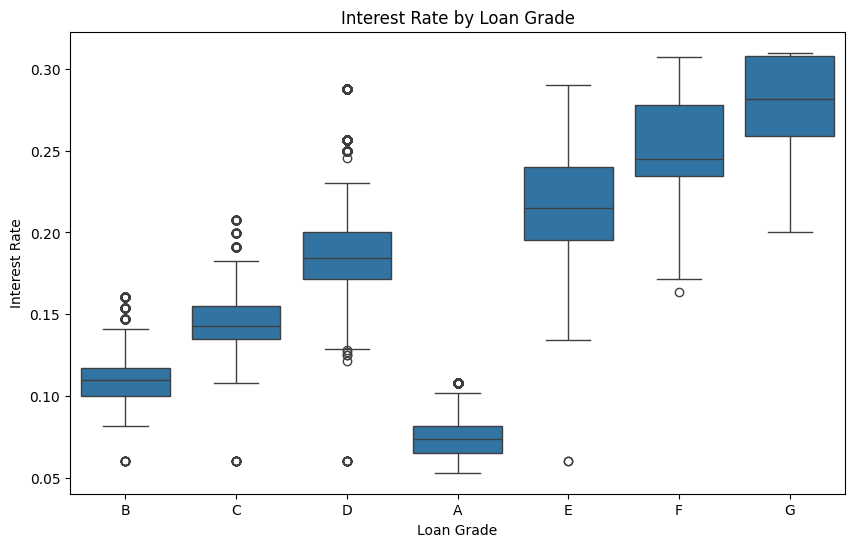

In [239]:
# Box plot of interest rate by loan grade
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=df)
plt.title('Interest Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.show()


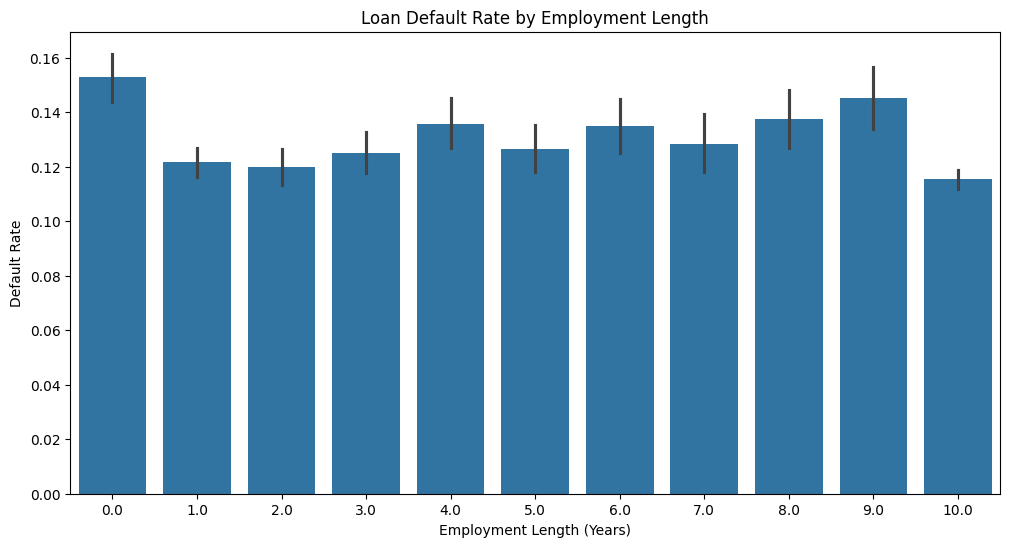

In [240]:
# Extract numeric value from 'emp_length'
df['emp_length_num'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length_num'].fillna(0, inplace=True)  # Handle '< 1 year' and 'n/a'

# Bar plot of loan status by employment length
plt.figure(figsize=(12, 6))
sns.barplot(x='emp_length_num', y='loan_status_binary', data=df)
plt.title('Loan Default Rate by Employment Length')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Default Rate')
plt.show()


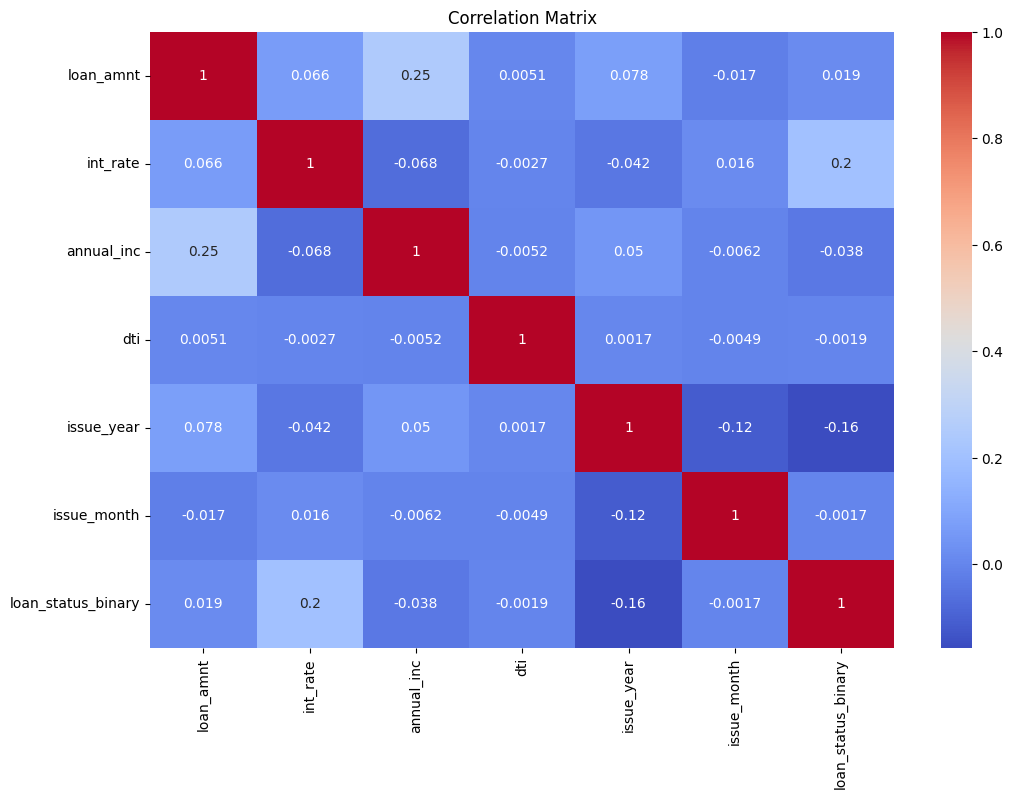

In [241]:
# Select numerical features for correlation matrix
numeric_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 
    'issue_year', 'issue_month', 'loan_status_binary'
]
correlation_matrix = df[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [242]:
# Define features (X) and target variable (y)
features = [
    'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
    'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
    'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 
    'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title', 
    'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 
    'home_ownership', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 
    'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 
    'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 
    'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 
    'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 
    'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
    'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
    'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_il_12m', 
    'open_il_24m', 'open_act_il', 'open_rv_12m', 'open_rv_24m', 'out_prncp', 
    'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'policy_code', 'pub_rec', 
    'pub_rec_bankruptcies', 'purpose', 'pymnt_plan', 'revol_bal', 'revol_util', 
    'sub_grade', 'tax_liens', 'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 
    'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 
    'total_cu_tl', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 
    'verification_status', 'zip_code'

]

In [243]:
def analyze_uniqueness(df):
    """
    Analyzes the number of unique values in all columns within a DataFrame, 
    regardless of their data type, and helps identify suitable candidates for visualization.

    Args:
        df: The Pandas DataFrame to analyze.

    Returns:
        A DataFrame with columns, unique value counts, and percentages.
        Also, displays a bar graph for the unique counts sorted from highest to lowest.
    """
    total_rows = len(df)

    # Calculate unique counts and percentages and store them in a DataFrame
    uniqueness_df = pd.DataFrame({
        "Unique Count": df.nunique(),
        "Unique Percentage": df.nunique() / total_rows * 100
    }).sort_values(by="Unique Count", ascending=False)

    # Print sorted output with unique counts and percentages
    print(uniqueness_df)

    # Create a bar graph to visualize the number of unique values
    plt.figure(figsize=(12, 6))
    plt.bar(uniqueness_df.index, uniqueness_df["Unique Count"])
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Number of Unique Values", fontsize=14)
    plt.title("Unique Value Counts per Column (Sorted)", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

    return uniqueness_df

# Example usage with pre-selected columns
# Assuming df and pre_hardship_fields are defined and valid
#try:
#    unique_counts_df = analyze_uniqueness(df[pre_hardship_fields])
#except ValueError as e:
#    print(f"Error: {e}")

                     Unique Count  Unique Percentage
total_pymnt                 92848          93.898727
total_pymnt_inv             90940          91.969135
total_rec_int               85944          86.916597
tot_cur_bal                 80487          81.397842
tot_hi_cred_lim             76186          77.048169
...                           ...                ...
initial_list_status             2           0.002023
term                            2           0.002023
application_type                2           0.002023
pymnt_plan                      1           0.001011
policy_code                     1           0.001011

[102 rows x 2 columns]


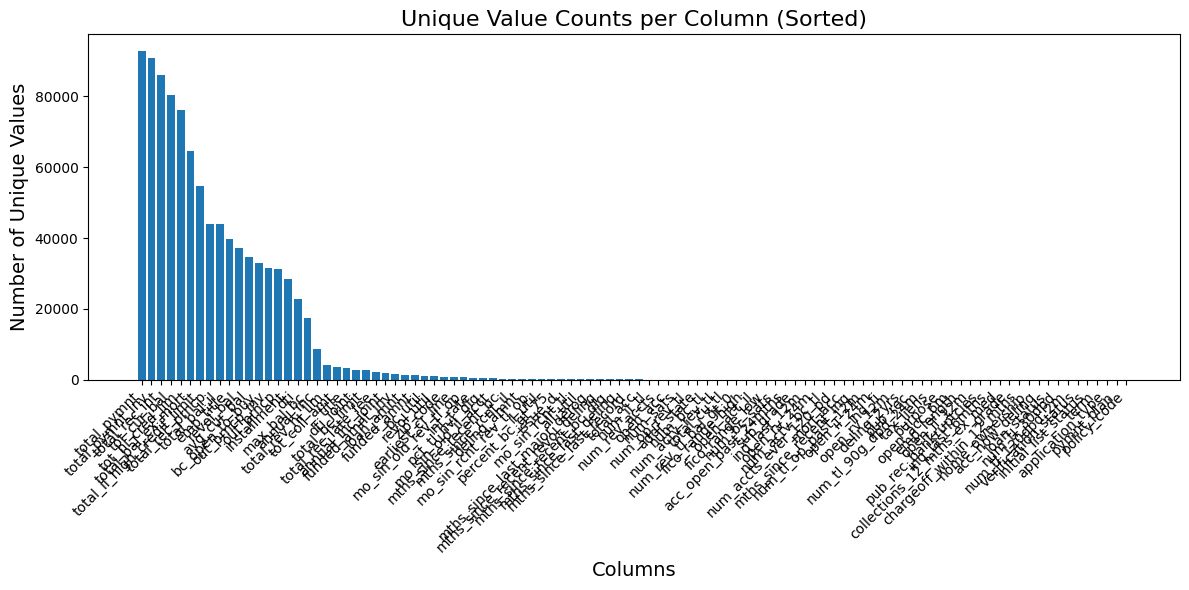

In [244]:
try:
    unique_counts_df = analyze_uniqueness(df[features])
except ValueError as e:
    print(f"Error: {e}")

# Feature Selection

In [245]:
features = features + list(home_ownership_df.columns) + list(emp_title_encoded.columns)

# Select only numerical columns from the feature list, excluding datetime types
X = df[features].select_dtypes(include=[np.number], exclude=['datetime', 'timedelta'])
y = df['loan_status_binary']


In [246]:
# Replace inf values with NaN, then fill with a reasonable value (e.g., column mean or zero)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values (e.g., from division by zero or log transformations)
#X.fillna(X.mean(), inplace=True) # careful repalces with mean
#X.fillna(df[column].mode()[0])
#X.fillna(df[column].median())
X.fillna(0)


,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,...,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0.0,1.0,59.0,48000.0,0.0,64756.0,0.0,0.0,0.0,1.0,...,83.29,0.0,183.66,2400.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,4.0,67.0,57000.0,0.0,6182.0,7741.0,40.5,0.0,0.0,...,5829.45,0.0,19666.71,35200.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,4.0,0.0,55000.0,0.0,22733.0,4521.0,54.8,0.0,0.0,...,846.67,0.0,5000.00,11400.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,4.0,25.0,43500.0,0.0,6973.0,43140.0,12.0,0.0,0.0,...,4318.62,0.0,7682.31,54500.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,5.0,43.0,48000.0,0.0,5641.0,17318.0,39.9,0.0,0.0,...,2605.68,0.0,14000.00,43900.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,2.0,67.0,60000.0,0.0,4062.0,8411.0,74.4,0.0,0.0,...,254.76,0.0,3300.00,34000.0,0.0,1.0,0.0,0.0,0.0,0.0
99996,0.0,15.0,37.0,150000.0,0.0,1761.0,28598.0,20.1,0.0,0.0,...,718.69,0.0,6000.00,63800.0,0.0,0.0,0.0,0.0,0.0,1.0
99997,0.0,6.0,57.0,48000.0,0.0,2383.0,1305.0,86.1,0.0,0.0,...,2305.20,0.0,1657.04,11300.0,0.0,0.0,0.0,0.0,0.0,1.0
99998,0.0,8.0,52.0,90000.0,0.0,19012.0,35397.0,33.7,0.0,0.0,...,564.83,0.0,2125.49,101200.0,0.0,1.0,0.0,0.0,0.0,0.0


In [247]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Create a pipeline with an imputer and SelectKBest
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Impute missing values with the median
    ('feature_selection', SelectKBest(mutual_info_classif, k=10))  # Select top 10 features
])

# Fit the pipeline to the data
X_new = pipeline.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[pipeline.named_steps['feature_selection'].get_support()]
print("Selected Features:", selected_features)

# Update X to include only the selected features
X = X[selected_features]

Selected Features: Index(['installment', 'int_rate', 'out_prncp', 'out_prncp_inv', 'policy_code',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_late_fee',
       'total_rec_prncp', 'home_ownership_MORTGAGE'],
      dtype='object')


In [248]:
# Step 1: Select only numeric columns
X = X.select_dtypes(include=[np.number])

# Step 2: Replace inf and -inf with NaN, then drop columns with NaN values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(axis=1, inplace=True)

# Step 3: Verify all values are finite and numeric
assert np.isfinite(X.values).all(), "Non-finite values remain in X."

# Calculate VIF
vif_data = calculate_vif(X)
print(vif_data)


                   Feature            VIF
0              installment       3.685067
1                 int_rate       1.366743
2                out_prncp  267024.684782
3            out_prncp_inv  267004.701558
4              policy_code      13.430401
5              total_pymnt    1361.091970
6          total_pymnt_inv    1338.320361
7       total_rec_late_fee       1.034237
8          total_rec_prncp      22.697440
9  home_ownership_MORTGAGE       1.038929


In [249]:
# Compute VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
print(vif_data)


                   Feature            VIF
0              installment       3.685067
1                 int_rate       1.366743
2                out_prncp  267024.684782
3            out_prncp_inv  267004.701558
4              policy_code      13.430401
5              total_pymnt    1361.091970
6          total_pymnt_inv    1338.320361
7       total_rec_late_fee       1.034237
8          total_rec_prncp      22.697440
9  home_ownership_MORTGAGE       1.038929


In [250]:
# Iteratively remove features with VIF > 5
threshold = 5  # Set the VIF threshold
while True:
    # Calculate VIF for all features
    vif_data = calculate_vif(X)
    print("Current VIF Data:")
    print(vif_data)
    
    # Check if there are any VIF values above the threshold
    max_vif = vif_data['VIF'].max()
    if max_vif > threshold:
        # Identify the feature with the highest VIF
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        print(f"Removing feature '{max_vif_feature}' with VIF: {max_vif}")
        
        # Drop the feature with the highest VIF
        X = X.drop(columns=[max_vif_feature])
    else:
        # Exit loop if all VIF values are below the threshold
        break

# Final VIF data
vif_data = calculate_vif(X)
print("Final VIF Data after feature selection:")
print(vif_data)


Current VIF Data:
                   Feature            VIF
0              installment       3.685067
1                 int_rate       1.366743
2                out_prncp  267024.684782
3            out_prncp_inv  267004.701558
4              policy_code      13.430401
5              total_pymnt    1361.091970
6          total_pymnt_inv    1338.320361
7       total_rec_late_fee       1.034237
8          total_rec_prncp      22.697440
9  home_ownership_MORTGAGE       1.038929
Removing feature 'out_prncp' with VIF: 267024.68478199583
Current VIF Data:
                   Feature          VIF
0              installment     3.684162
1                 int_rate     1.366175
2            out_prncp_inv     2.312633
3              policy_code    13.421731
4              total_pymnt  1360.762884
5          total_pymnt_inv  1337.979129
6       total_rec_late_fee     1.034230
7          total_rec_prncp    22.696691
8  home_ownership_MORTGAGE     1.038918
Removing feature 'total_pymnt' with VIF: 136

In [251]:
# Class distribution before resampling
print("Before Resampling:")
print(y.value_counts())


Before Resampling:
loan_status_binary
0    86483
1    12398
Name: count, dtype: int64


In [252]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample dataset
X_resampled, y_resampled = smote.fit_resample(X, y)


In [253]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [254]:
# Initialize Logistic Regression model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Train model
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate model using cross-validation
cv_scores = cross_val_score(baseline_model, X_resampled, y_resampled, cv=5, scoring='f1')
print(f"Logistic Regression CV F1 Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Logistic Regression CV F1 Score: 0.8594 ± 0.0024


In [255]:
# Initialize Random Forest model
challenger_model = RandomForestClassifier(random_state=42)

# Train model
challenger_model.fit(X_train, y_train)

# Predict on test set
y_pred_challenger = challenger_model.predict(X_test)

# Evaluate model using cross-validation
cv_scores_rf = cross_val_score(challenger_model, X_resampled, y_resampled, cv=5, scoring='f1')
print(f"Random Forest CV F1 Score: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")


Random Forest CV F1 Score: 0.9589 ± 0.0256


In [256]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model using accuracy, precision, recall, and F1 score.

    Parameters:
    y_true (array): True labels
    y_pred (array): Predicted labels
    model_name (str): Name of the model

    Returns:
    None
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Logistic Regression Evaluation Metrics:
Accuracy     : 0.8543
Precision    : 0.8240
Recall       : 0.9010
F1 Score     : 0.8608
ROC-AUC Score: 0.8543

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     17297
           1       0.82      0.90      0.86     17297

    accuracy                           0.85     34594
   macro avg       0.86      0.85      0.85     34594
weighted avg       0.86      0.85      0.85     34594



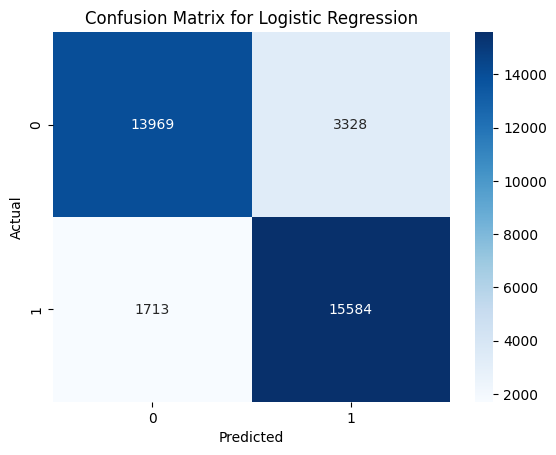

In [257]:
evaluate_model(y_test, y_pred_baseline, 'Logistic Regression')


Random Forest Evaluation Metrics:
Accuracy     : 0.9634
Precision    : 0.9627
Recall       : 0.9642
F1 Score     : 0.9634
ROC-AUC Score: 0.9634

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17297
           1       0.96      0.96      0.96     17297

    accuracy                           0.96     34594
   macro avg       0.96      0.96      0.96     34594
weighted avg       0.96      0.96      0.96     34594



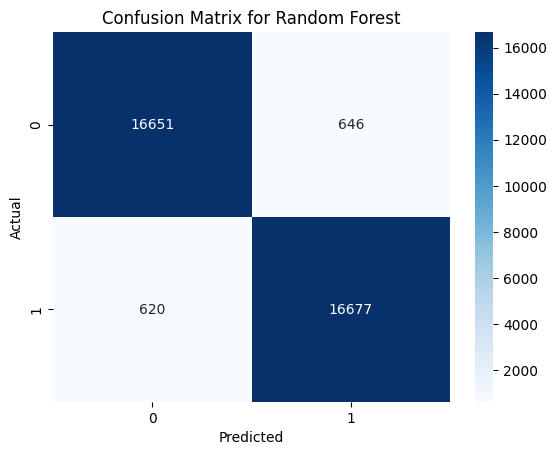

In [ ]:
evaluate_model(y_test, y_pred_challenger, 'Random Forest')

# Hyper tunning

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 4, 6]
}

# Initialize RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
randomized_search.fit(X_train, y_train)

# Best parameters
best_params = randomized_search.best_params_
print("Best Parameters:", best_params)


In [ ]:
# Train Random Forest with best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict on test set
y_pred_best = best_model.predict(X_test)

# Evaluate best model
evaluate_model(y_test, y_pred_best, 'Best Random Forest')


# Model evaluation

In [ ]:
# Feature importance from Random Forest
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importance_df)


In [ ]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Sample test data for SHAP analysis
X_test_sample = X_test.sample(n=1000, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)


In [ ]:
# SHAP summary plot for the positive class
shap.summary_plot(shap_values[1], X_test_sample)


# Save model

In [ ]:
import joblib

# Save the best model
joblib.dump(best_model, 'best_random_forest_model.joblib')

# Save the scaler and encoder
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(encoder, 'encoder.joblib')


# Conclusion